In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from expipe_plugin_cinpla.widgets import browser
from expipe import browser

15:24:48 [I] klustakwik KlustaKwik2 version 0.2.6


In [42]:
import matplotlib.pylab as plt
import numpy as np
import pickle as pkl
import os
import quantities as pq

In [43]:
import visualstimulation as vs
import vian
import expipe

In [15]:
%matplotlib notebook

In [5]:
project_path = "C:\\apps\expipe-projects\probe_v1"

project = expipe.get_project(project_path)
actions = project.actions

In [4]:
actions

In [6]:
action_id = '1053-010319-8'
action = actions[action_id]

In [7]:
data_path = vian.get_data_path(action)

Project path: C:\apps\expipe-projects\probe_v1
Data path: actions\1053-010319-8\data\main.exdir


In [8]:
epochs = vian.load_epochs(data_path)

In [8]:
epochs

[Epoch
 annotations: {'exdir_path': '/epochs/open-ephys-epochs/rhythm_fpga_100',
   'lazy_shape': None,
   'node_id': 100,
   'processor': 'rhythm_fpga',
   'provenance': 'open-ephys'},
 Epoch
 annotations: {'exdir_path': '/epochs/psychopy',
   'lazy_shape': None,
   'provenance': 'psychopy'}]

In [66]:
channel_idx = 0
sptr = vian.load_spiketrains(data_path, channel_idx)

In [70]:
pkl_path = os.path.join('C:/apps/temp', action_id + '_sptr.pkl')
with open(pkl_path, 'wb') as outfile:
    pkl.dump(sptr, outfile)

In [9]:
channel_idx = 0
pkl_path = os.path.join('C:/apps/temp', action_id + '_sptr.pkl')
with open(pkl_path, 'rb') as infile:
    sptr = pkl.load(infile)

In [10]:
oe_epoch = epochs[0]
ps_epoch = epochs[1]

<IPython.core.display.Javascript object>


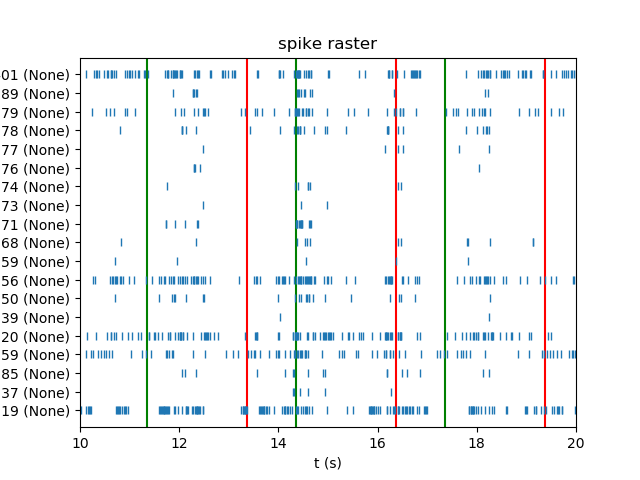

In [34]:
def raster_plot(ax, spiketrains, T=[0., 10.], epo=None):
    '''
    Arguments
    ---------
    ax : matplotlib.axes._subplots.AxesSubplot
    spiketrains : list of neo.SpikeTrain objects
    T : length 2 list/tuple of floats
        time interval in seconds
    epo : None or neo.Epoch object
        show onset/offset times of stimuli
    '''
    yticklabels = []
    for i, spiketrain in enumerate(sptr):
        yticklabels.append('{} ({})'.format(spiketrain.name, spiketrain.description))
        ax.plot(spiketrain, np.zeros(spiketrain.size)+i, 'C0|')
    if epochs is not None:
        axis = ax.axis('tight')
        ax.vlines(epochs[0].times, axis[2], axis[3], 'g')
        ax.vlines((epochs[0].times+epochs[0].durations), axis[2], axis[3], 'r')        
    ax.set_yticks(range(len(sptr)))
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel('unit id')
    ax.set_xlim(T)
    ax.set_xlabel('t (s)')
    ax.set_title('spike raster')
fig, ax = plt.subplots(1,1)
raster_plot(ax, sptr, T=[10., 20.], epo=epochs)

In [38]:
def plot_psth(st, epoch, fig=None, axes=None, lags=(-0.1*pq.s, 1*pq.s), bin_size=0.01*pq.s, 
              marker='|', color='C0', n_trials=10,  histtype='bar'):
    '''
    Parameters:
    st : neo.SpikeTrain
    epoch : neo.Epoch
    lags : tuple of Quantity scalars
    bin_size : Quantity scalar
    color : mpl color 
    n_trials : int
        number of trials to include in PSTH
    '''
    labels = np.unique(epoch.labels, axis=-1)
    bins = np.linspace(lags[0], lags[1], int((lags[1]-lags[0])//bin_size)+1)
    flattenlist = lambda lst: [item for sublist in lst for item in sublist]
    
    if fig is None:
        fig, axes = plt.subplots(2, len(labels), sharex=True, sharey='row', figsize=(20, 10))
        fig.suptitle('unit {} ({})'.format(st.name, st.description))
    for i, label in enumerate(labels):
        axes[0, i].set_xlim(lags)
        axes[1, i].set_xlim(lags)

        sts = []
        for h, epo in enumerate(epoch[epoch.labels == label]):
            if h < n_trials:
                st_ = st.time_slice(t_start=(epo+lags[0]).simplified, 
                                    t_stop=(epo+lags[1]).simplified)
                sts.append((st_.times.simplified - epo.simplified).tolist())
                axes[0, i].plot(sts[h], np.zeros(len(sts[h])) + h, marker, color=color)

        axes[0, i].set_title('{}'.format(label), fontsize='x-small')
        axes[1, i].set_xlabel('lag (s)')
        axes[1, i].hist(flattenlist(sts), bins=bins, color=color, histtype=histtype)
        axes[1, i].axvline(0, color='r')
        if i == 0:
            axes[0, i].set_ylabel('trial #')
            axes[1, i].set_ylabel('#')
            
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, axes

In [44]:
for sp in sptr:
    plot_psth(sp, ps_epoch, lags=(-0.5*pq.s, 1*pq.s), n_trials=np.inf)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


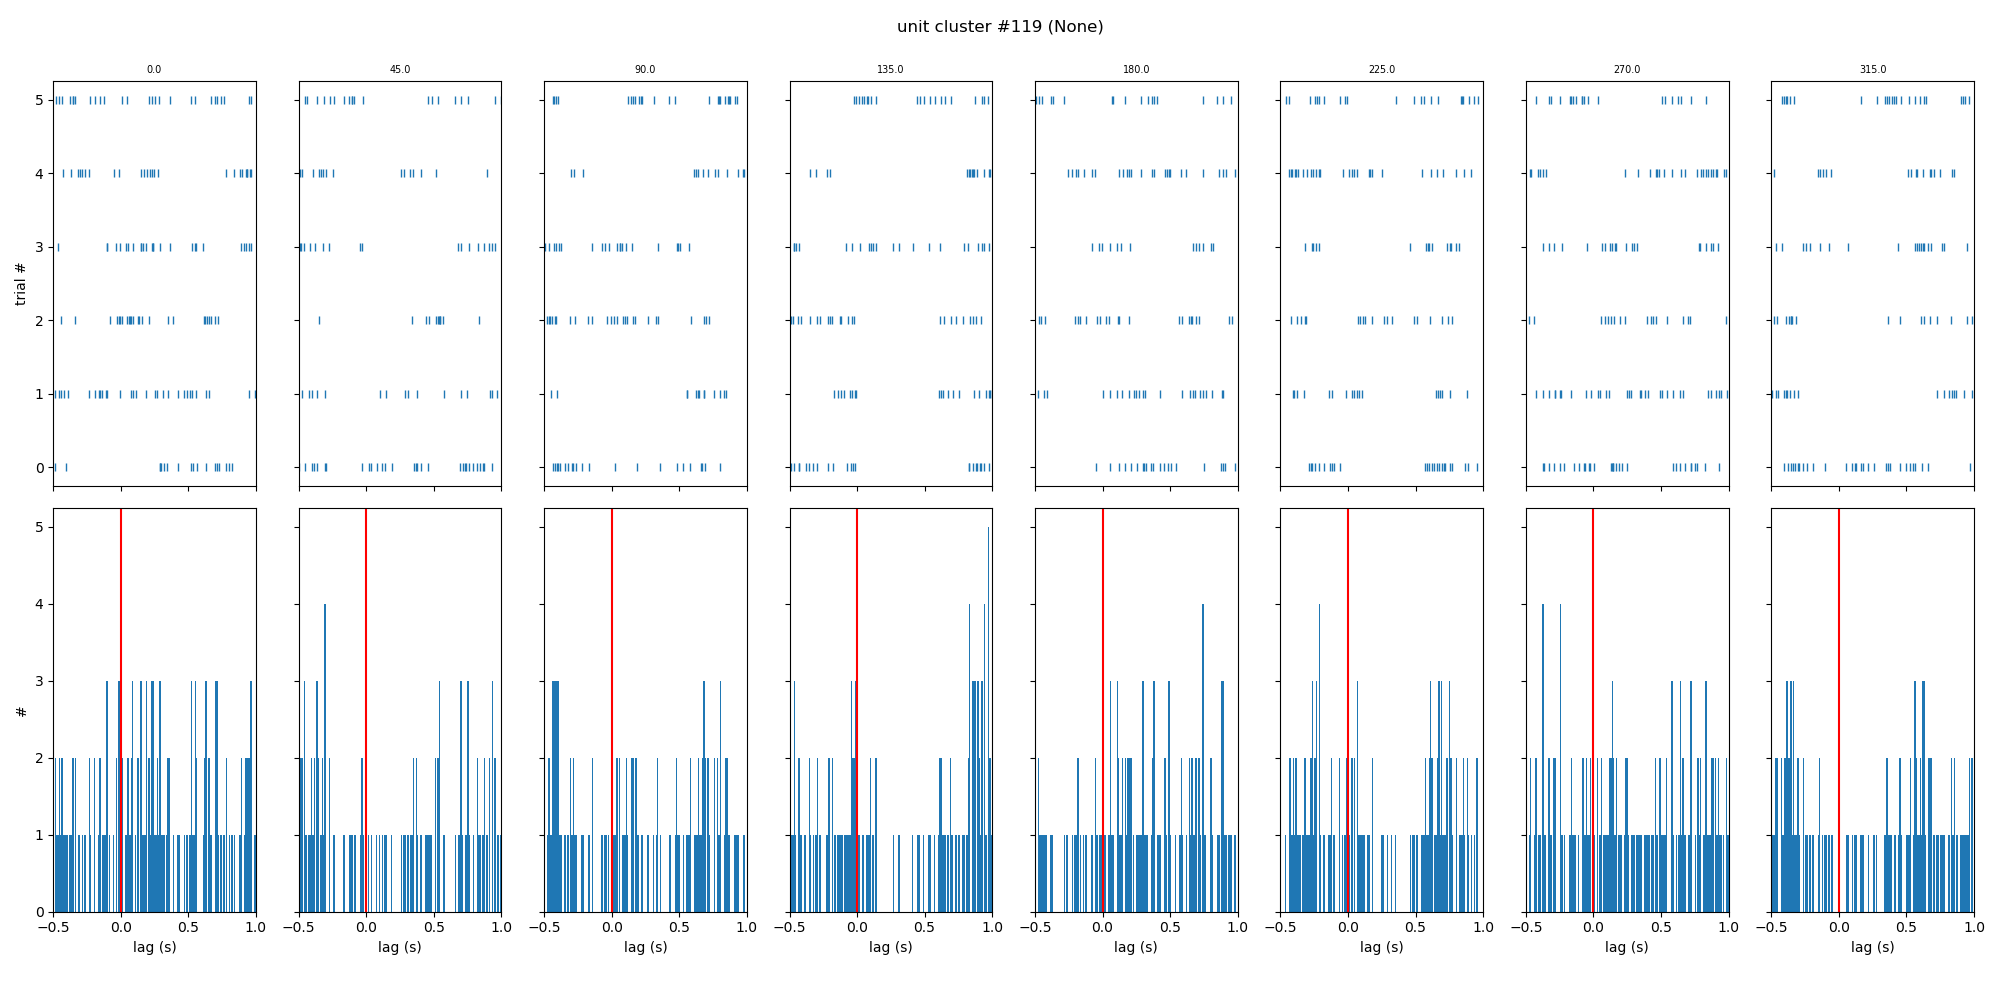

(<Figure size 2000x1000 with 16 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000235B35789E8>,
       dtype=object))

In [49]:
plot_psth(sptr[0], ps_epoch, lags=(-0.5*pq.s, 1*pq.s), bin_size=0.01*pq.s, n_trials=np.inf)

In [15]:
for st in sptr:
    print(st)

[9.91333333e-02 1.19566667e-01 1.50966667e-01 ... 1.70711300e+02
 1.70820233e+02 1.70879867e+02] s
[  9.33216667   9.35636667  14.29383333  14.3181      14.42626667
  14.60236667  14.93906667  16.2654      24.2194      24.55
  27.9004      31.44306667  31.4527      31.47086667  39.5402
  42.1835      43.62856667  46.61823333  47.0176      49.32386667
  53.75103333  55.9291      55.99763333  56.0986      58.73576667
  59.12746667  59.20563333  59.3271      59.35963333  61.90476667
  61.96443333  67.28273333  73.26573333  75.39046667  75.60133333
  76.6793      77.7769      85.492       89.4526      89.8187
  90.07423333  96.7115     100.6308     102.9396     102.94616667
 108.91693333 112.2887     112.65976667 116.9883     119.72546667
 120.2891     126.12226667 126.32766667 133.12446667 135.09223333
 135.16353333 139.05373333 140.97956667 142.43553333 142.55513333
 142.6517     143.23223333 144.68126667 146.89113333 149.25696667
 153.7978     154.7486     155.8437     155.8649     156.

 170.7825     170.83653333 170.86063333 170.8912    ] s
[8.34000000e-02 1.89833333e-01 3.97533333e-01 4.53000000e-01
 4.91533333e-01 8.99633333e-01 9.44733333e-01 9.63400000e-01
 3.87863333e+00 3.89123333e+00 4.07420000e+00 4.14523333e+00
 4.19993333e+00 4.23610000e+00 4.72693333e+00 5.53220000e+00
 5.79290000e+00 6.13600000e+00 9.36430000e+00 9.51260000e+00
 1.07048000e+01 1.15924667e+01 1.18477667e+01 1.19035000e+01
 1.19236333e+01 1.21418333e+01 1.24762333e+01 1.24912667e+01
 1.39868333e+01 1.43252333e+01 1.44226000e+01 1.44529667e+01
 1.45648667e+01 1.45668000e+01 1.46182333e+01 1.46241333e+01
 1.47018333e+01 1.49412000e+01 1.54682333e+01 1.62500667e+01
 1.64280333e+01 1.64811000e+01 1.67473333e+01 1.82738333e+01
 2.08893333e+01 2.09184667e+01 2.09615333e+01 2.37171667e+01
 2.37390000e+01 2.37605000e+01 2.37636667e+01 2.37679000e+01
 2.39135000e+01 2.40144667e+01 2.41172000e+01 2.41657000e+01
 2.42123333e+01 2.60387667e+01 2.62597000e+01 2.78636667e+01
 2.78957333e+01 2.96113333e+0

 1.69680733e+02] s
[2.71333333e-02 6.92666667e-02 1.04800000e-01 ... 1.70724333e+02
 1.70857100e+02 1.70893600e+02] s
[  0.4432       3.85833333   3.88593333   3.9638       7.6316
  10.6988      11.96196667  14.5646      16.36693333  17.82636667
  21.26233333  23.94276667  26.06736667  26.13433333  27.90066667
  29.07513333  31.62116667  31.78863333  35.49326667  39.13456667
  39.34756667  39.6193      40.5529      41.83506667  42.30726667
  49.35196667  52.57823333  53.3532      53.6545      54.30953333
  62.20173333  64.3         64.48423333  65.08356667  67.51356667
  69.82203333  70.2406      70.3655      70.52853333  73.08323333
  73.10933333  76.05166667  76.63046667  77.97316667  78.95506667
  80.64656667  84.2446      85.66056667  87.9044      90.10053333
  90.25093333  93.8924      96.41673333  96.5853      96.71266667
  96.9192     100.02116667 102.94073333 103.003      104.53506667
 104.6646     107.96896667 114.66166667 117.18913333 117.2284
 118.91903333 118.96823333 119.8

 1.70303567e+02 1.70346933e+02] s
[1.16966667e-01 1.52700000e-01 1.64466667e-01 1.79533333e-01
 1.90966667e-01 2.18433333e-01 2.24600000e-01 2.29133333e-01
 2.35300000e-01 2.40266667e-01 2.67866667e-01 2.69533333e-01
 3.14366667e-01 4.28100000e-01 4.69100000e-01 5.66600000e-01
 9.75033333e-01 2.24066667e+00 2.24256667e+00 2.28726667e+00
 3.84683333e+00 3.85713333e+00 3.88083333e+00 3.88326667e+00
 3.88496667e+00 3.89456667e+00 3.90333333e+00 3.90730000e+00
 3.90863333e+00 3.97563333e+00 3.98050000e+00 4.01216667e+00
 4.19496667e+00 4.41226667e+00 6.15210000e+00 6.16626667e+00
 9.73016667e+00 1.17363667e+01 1.17387000e+01 1.19068667e+01
 1.21251333e+01 1.23593333e+01 1.23731333e+01 1.43452667e+01
 1.43599000e+01 1.43760667e+01 1.43840333e+01 1.44205000e+01
 1.44302000e+01 1.44466333e+01 1.44489667e+01 1.44698667e+01
 1.44728667e+01 1.46176667e+01 1.46357000e+01 1.46511333e+01
 2.09281333e+01 2.38007000e+01 2.38056667e+01 2.38315333e+01
 2.38474667e+01 2.38526667e+01 2.39126333e+01 2.395

 164.40673333 164.65313333 165.5638     165.93713333] s
[9.55333333e-02 2.66133333e-01 2.75133333e-01 2.84866667e-01
 3.86940000e+00 3.87470000e+00 4.16820000e+00 9.29833333e+00
 1.17490000e+01 1.43445000e+01 1.43999000e+01 1.45913333e+01
 1.45979000e+01 1.46444000e+01 1.64147000e+01 1.64789000e+01
 2.08985333e+01 2.14578000e+01 2.37949667e+01 2.38050667e+01
 2.39230000e+01 2.96266000e+01 2.98900333e+01 3.12747000e+01
 3.14344000e+01 3.14386333e+01 3.15071000e+01 3.35563333e+01
 3.38999667e+01 3.91224333e+01 3.91302000e+01 3.92145333e+01
 3.96128000e+01 4.42995000e+01 4.65604333e+01 4.80942667e+01
 4.95191333e+01 5.36750333e+01 5.36808667e+01 5.43061000e+01
 5.59245333e+01 5.66395667e+01 5.89964667e+01 5.90022000e+01
 5.90131000e+01 5.96273333e+01 5.96333667e+01 6.10341333e+01
 6.18852667e+01 6.19268333e+01 6.20831333e+01 6.21167333e+01
 6.22103333e+01 6.41115333e+01 6.50850667e+01 6.56363333e+01
 7.31625667e+01 7.54403667e+01 7.55660000e+01 7.61470000e+01
 7.78086333e+01 7.78980000e+0

 1.70672400e+02 1.70786367e+02 1.70825400e+02] s
[  3.99146667   4.36743333   6.10133333   9.4601       9.4643
   9.73076667   9.7371      12.29786667  12.30453333  12.30906667
  12.41656667  18.0445      21.55486667  24.1565      35.4722
  39.63076667  43.5919      46.56986667  46.57486667  46.9902
  46.99486667  49.48936667  56.64146667  56.64736667  59.04663333
  64.03956667  64.3604      67.8113      70.20873333  70.21326667
  73.07406667  73.3037      75.58603333  75.5916      78.22536667
  80.50186667  80.89073333  80.89446667  84.34143333  85.7758
  87.64523333  87.74993333  88.25416667  90.41113333  90.4197
  93.9448      96.61916667  96.80056667 100.60263333 100.60633333
 100.61196667 112.0113     112.0196     112.24343333 112.43203333
 112.44496667 113.94643333 113.95103333 114.25356667 124.43503333
 124.43893333 126.33496667 129.6122     129.62016667 129.74883333
 129.8592     129.86406667 133.24613333 133.29116667 133.2962
 133.41023333 139.15823333 139.16886667 139.4579666

 1.70335800e+02 1.70836833e+02] s
[1.69333333e-02 1.24266667e-01 1.54633333e-01 ... 1.70843567e+02
 1.70905200e+02 1.70956400e+02] s
[1.22500000e-01 1.32766667e-01 2.01033333e-01 2.08566667e-01
 2.50433333e-01 4.61166667e-01 5.85333333e-01 3.89356667e+00
 3.91976667e+00 3.93463333e+00 3.95500000e+00 3.97216667e+00
 3.97916667e+00 3.99603333e+00 3.99743333e+00 4.24153333e+00
 6.15613333e+00 1.18693333e+01 1.22796333e+01 1.22846667e+01
 1.22895000e+01 1.23414667e+01 1.23573333e+01 1.43816333e+01
 1.43953333e+01 1.44121000e+01 1.44464000e+01 1.45201000e+01
 1.45343667e+01 1.46375667e+01 1.46860667e+01 1.63216667e+01
 1.81577333e+01 1.82197667e+01 2.09297000e+01 2.37923667e+01
 2.38246333e+01 2.38347667e+01 2.38874667e+01 2.39156667e+01
 2.39326333e+01 2.39387667e+01 2.41441333e+01 2.51241333e+01
 2.58339333e+01 2.96719333e+01 2.97419333e+01 2.97472333e+01
 3.15187333e+01 3.53659667e+01 3.55628333e+01 3.55980333e+01
 3.92073000e+01 3.92185000e+01 3.93257333e+01 3.93779000e+01
 4.21086000e+

### How to plot spiketrains?

<IPython.core.display.Javascript object>


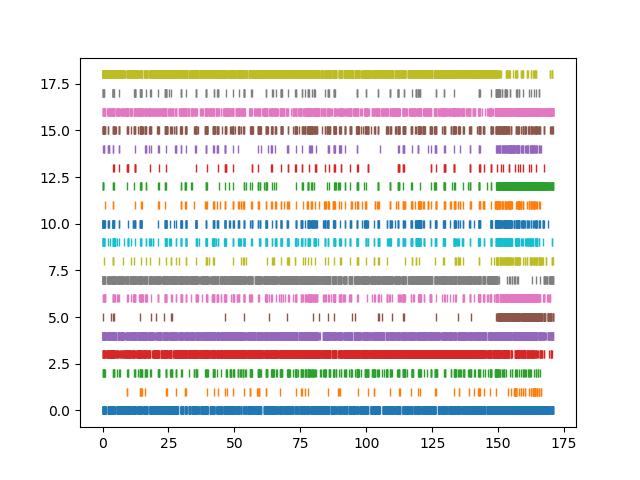

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i, st in enumerate(sptr):
    ax.plot(st.times, i * np.ones(len(st)), '|', ls='')

### How to plot waveforms?

In [35]:
wf = sptr[0].waveforms
print(wf.shape)

(2500, 32, 90)


In [36]:
wf_mean = np.mean(wf, axis=0)
print(wf_mean.shape)

(32, 90)


C:\Users\malinbro\AppData\Local\Continuum\anaconda3\envs\expipe\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


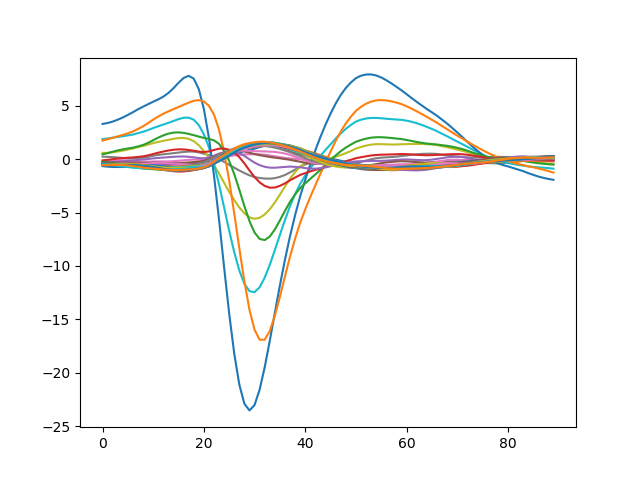

In [37]:
plt.figure()
_ = plt.plot(wf_mean.T)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i, w in enumerate(wf_mean):
    _ = ax.plot(w + i*25, 'k')

### How to load LFP?

In [20]:
lfp = vian.load_lfp(data_path)

<IPython.core.display.Javascript object>


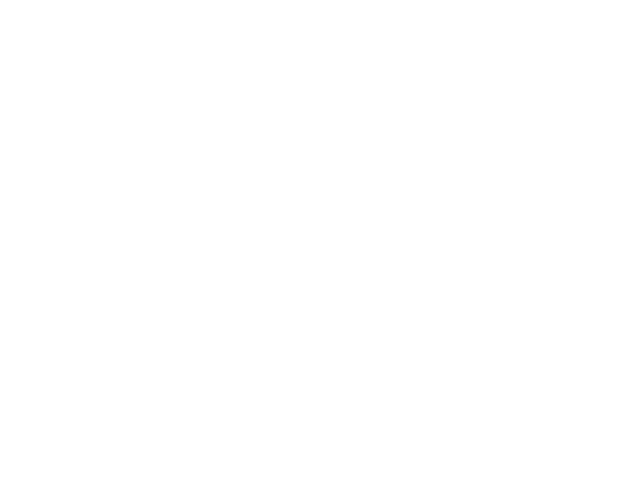

MemoryError: 

In [24]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(np.corrcoef(lfp), vmin=-1, vmax=1)
ax.axis(ax.axis('equal'))
fig.colorbar(im)

<IPython.core.display.Javascript object>


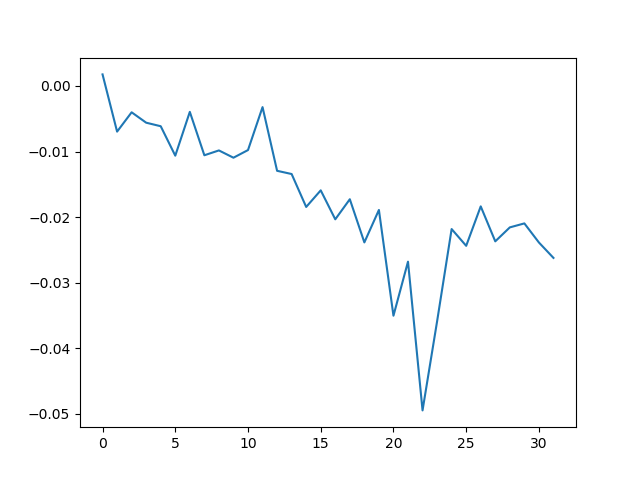

In [25]:
plt.figure()
plt.plot(lfp[0])

<IPython.core.display.Javascript object>


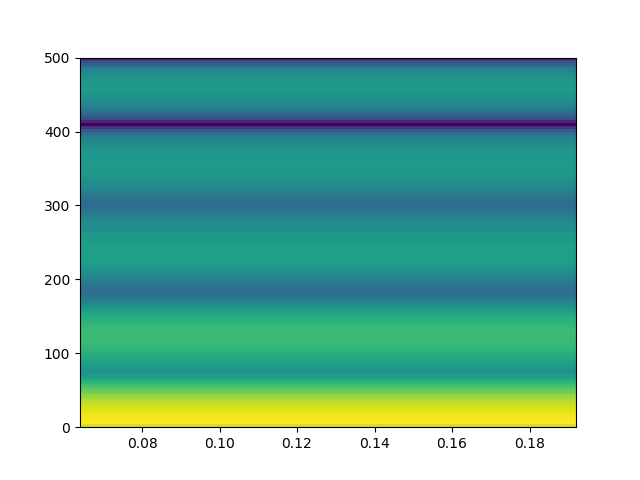

C:\Users\malinbro\AppData\Local\Continuum\anaconda3\envs\expipe\lib\site-packages\matplotlib\mlab.py:1246: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=32).
  "(=%d) >= signal length (=%d)." % (NFFT, len(x)))


In [28]:
plt.figure()
_ = plt.specgram(np.array(lfp[0]), Fs=1000)

<IPython.core.display.Javascript object>


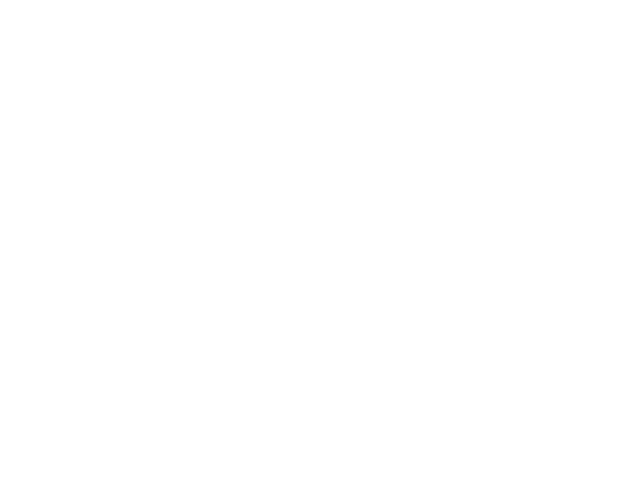

KeyboardInterrupt: 

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
for ciao in lfp:
    _ = ax.psd(np.array(ciao), NFFT=1024, Fs=1000)

In [30]:
type(lfp)

neo.core.analogsignal.AnalogSignal

In [31]:
oe_epoch = epochs[0]
ps_epoch = epochs[1]

In [32]:
orients = ps_epoch.labels
print(orients)

[180.   0.  90. 225. 315. 135.  45. 270. 270.  90. 315.   0. 180. 135.
  45. 225. 315.  45.   0.  90. 180. 270. 135. 225. 180. 315.   0. 135.
  45. 225.  90. 270. 315.  90. 180. 270.  45. 135.   0. 225.   0. 135.
  90. 315. 180.  45. 225. 270.] deg


In [33]:
# make trials 
import quantities as pq
trials = vian.make_spiketrain_trials(sptr[1], oe_epoch)
vian.add_orientation_to_trials(trials, orients)

In [34]:
print(trials[0].annotations)

{'orient': array(180.) * deg}


In [24]:
        fig, ax = plt.subplots()

    trial_mean_isis = []
    trial_median_isis = []
    trial_std = []
    x_axis = []
    for i, sptr in enumerate(trials):
        if len(sptr) >= 4:
            sptr_isi = isi(sptr)
            trial_median_isis.append(np.median(sptr_isi).magnitude)
            trial_mean_isis.append(np.mean(sptr_isi).magnitude)
            trial_std.append(np.std(sptr_isi).magnitude)
            x_axis.append(i+1)
        
    
    x_axis = np.array(x_axis)
    with sns.axes_style("whitegrid"):
        median = ax.barh(x_axis-height/2, trial_median_isis, height=height*1.03, color='b', align='center')
        mean = ax.barh(x_axis+height/2, trial_mean_isis, height=height*1.03, xerr=trial_std, color='r', align='center')
        ax.legend(('Median', 'Mean'))
    return ax

IndentationError: unexpected indent (<ipython-input-24-3fdd04a45002>, line 3)

In [56]:
% autoreload 2
import vian

<IPython.core.display.Javascript object>


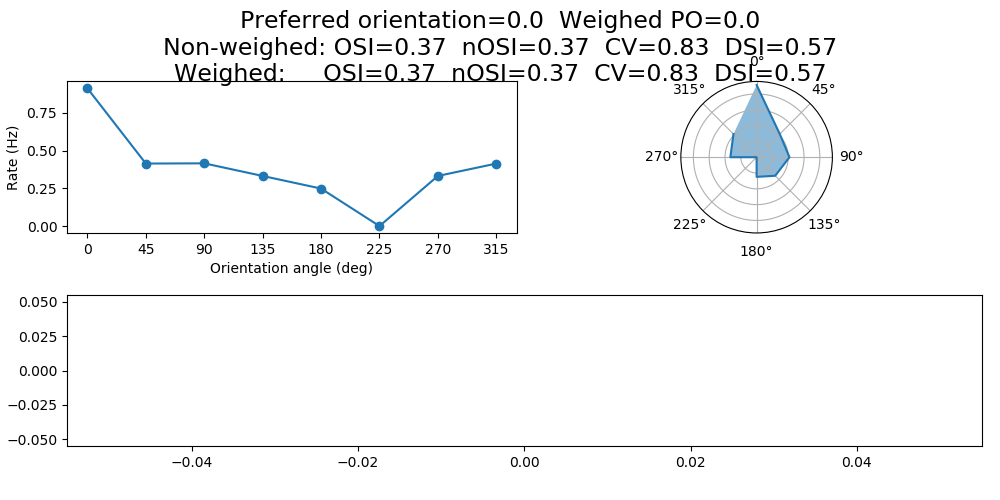

C:\Users\malinbro\AppData\Local\Continuum\anaconda3\envs\expipe\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\malinbro\AppData\Local\Continuum\anaconda3\envs\expipe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\malinbro\AppData\Local\Continuum\anaconda3\envs\expipe\lib\site-packages\numpy\lib\histograms.py:815: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [57]:
fig = vian.plot_tuning_overview(trials, [1])

<IPython.core.display.Javascript object>


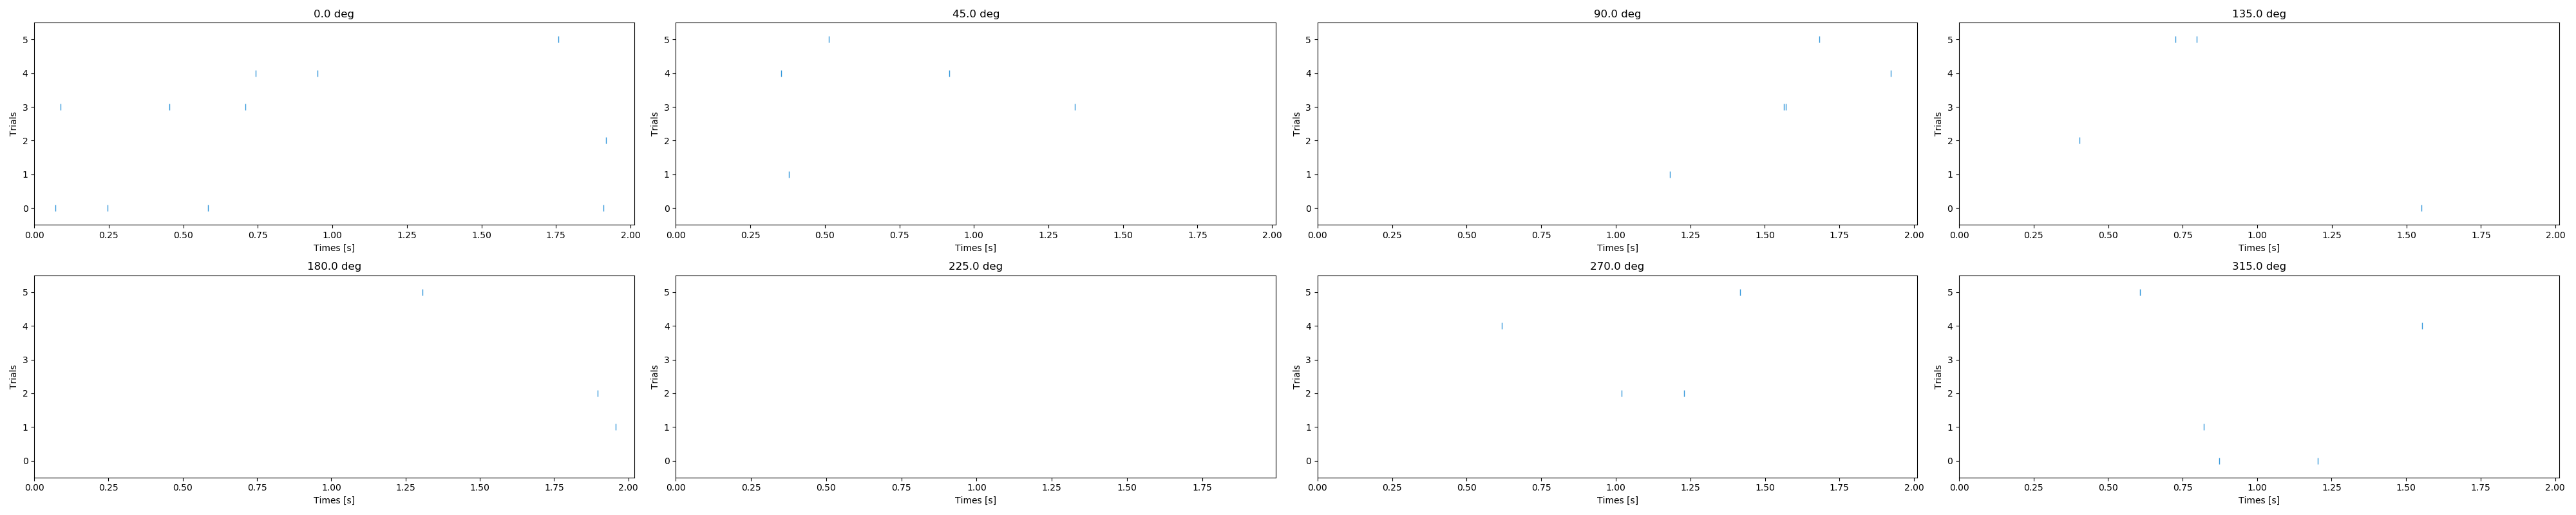

In [50]:
fig = vian.orient_raster_plots(trials)


<IPython.core.display.Javascript object>


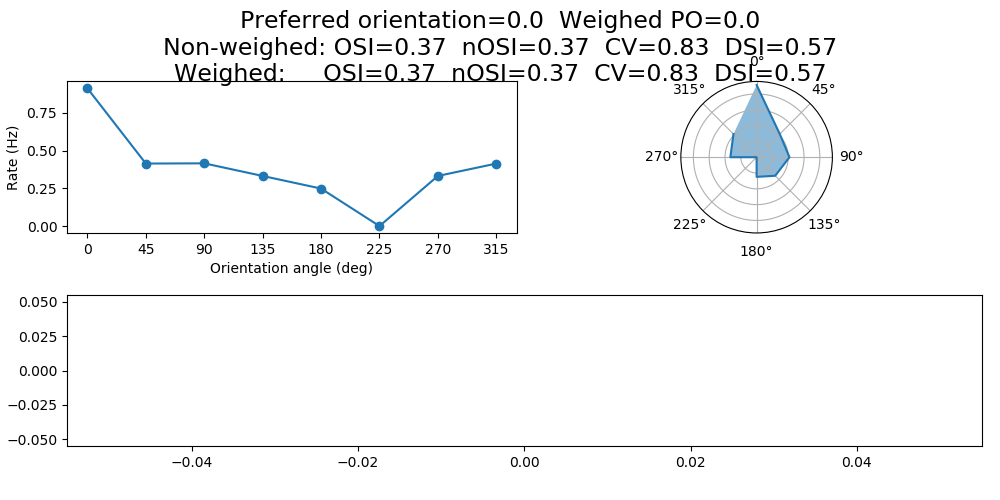

C:\Users\malinbro\AppData\Local\Continuum\anaconda3\envs\expipe\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\malinbro\AppData\Local\Continuum\anaconda3\envs\expipe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\malinbro\AppData\Local\Continuum\anaconda3\envs\expipe\lib\site-packages\numpy\lib\histograms.py:815: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [58]:
fig = vian.plot_tuning_overview(trials, [1])

In [ ]:
import visualstimulation as vs
import os

In [ ]:
project = os.path.realpath("C:\\apps\\expipe-project\\MROS_V2")
action_id = "1823-060219-2"
o = vs.represent.visual_data(project, action_id)

In [ ]:
o_sptr = vs.load_spiketrains(str(o.data_path), 0)

In [ ]:
o.get_plot()